<a href="https://colab.research.google.com/github/0xtaha/image-super-resloution-for-remote-sensing/blob/main/colab_notebooks/SR_2X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.optimize import fmin_l_bfgs_b
from sklearn.model_selection import train_test_split
# from scipy.misc import imageio.imwrite
# imwrite is decaprecated using save_img from keras insted
from keras.preprocessing.image import save_img
import warnings
warnings.filterwarnings('ignore')
import tarfile

%matplotlib inline
import importlib
import tensorflow as tf
import tensorflow.keras as K
import math, datetime, pandas as pd, numpy as np
import matplotlib.pyplot as plt,random, pickle, glob, os
import sklearn
from PIL import Image
import tarfile
import cv2
import random

## Loading data

Download and extract training data by uncommenting below cell

In [ ]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip /content/UCMerced_LandUse.zip -d /content/;

--2021-02-07 07:40:52--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  99.6MB/s    in 4.3s    

2021-02-07 07:40:56 (73.4 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]

Archive:  /content/UCMerced_LandUse.zip
   creating: /content/UCMerced_LandUse/Images/
   creating: /content/UCMerced_LandUse/Images/agricultural/
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural00.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural01.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural02.tif  
  inflating: /content/UCMerced_LandUse/Images

In [ ]:
Land_images = glob.glob('/content/UCMerced_LandUse/Images/**/*.tif') #returns path of images
print(len(Land_images)) #contains 13243 images

2100


In [ ]:
train_list, val_list = train_test_split(Land_images, random_state = 32, test_size=0.3 , train_size = 0.7)

In [ ]:
len(train_list)

1470

In [ ]:
len(val_list)

630

In [ ]:
input_size = 256

In [ ]:
def read_image(img_path,scale=2):
    global input_size
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_lr = cv2.resize(img, (int(input_size / scale ),int(input_size / scale )),interpolation=cv2.INTER_CUBIC)
    img_hr = cv2.resize(img, (input_size,input_size))
    return img_lr,img_hr


(256, 256, 3)


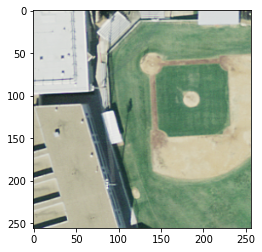

In [ ]:
_,img=read_image(train_list[100])
print(img.shape)
plt.imshow(img)

(256, 256, 3)


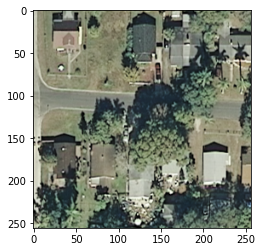

In [ ]:
_,img=read_image(val_list[0])
print(img.shape)
plt.imshow(img)

## Super Resolution Model

In [ ]:
def conv_block(x, filters, kernel, stride=(1,1), mode='same', act=True):
    x = K.layers.Conv2D(filters, kernel_size=kernel, strides=stride, padding=mode)(x)
    return K.layers.Activation('relu')(x) if act else x

In [ ]:
def res_block(ip,nf=16):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return K.layers.Add()([x,ip])

In [ ]:
def up_block(x,nf):
    x = K.layers.UpSampling2D()(x)
    x = conv_block(x,nf,kernel=(1,1))
    return x

In [ ]:
def get_srmodel(shape=(None,None,3)):
    inp=K.Input(shape)

    x=conv_block(inp, 16, 3, (1,1))
    for i in range(5): x=res_block(x,16)
    

    x=up_block(x,nf=32)
#     for i in range(2): x=res_block(x,32)

#     x=up_block(x,nf=64)
#     for i in range(1): x=res_block(x,64)
    
    x = K.layers.Conv2D(3,(3,3),padding='same')(x)
    return inp,x

In [ ]:
inp,outp=get_srmodel((None,None,3))
sr_model=K.Model(inp,outp)
sr_model.summary(110)

Model: "model"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_1 (InputLayer)                [(None, None, None, 3)] 0                                                 
______________________________________________________________________________________________________________
conv2d (Conv2D)                     (None, None, None, 16)  448          input_1[0][0]                        
______________________________________________________________________________________________________________
activation (Activation)             (None, None, None, 16)  0            conv2d[0][0]                         
______________________________________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, None, None, 16)  2320         activation[0][0]        

### loading vgg for calculating perceptual loss from one of its layer

In [ ]:
vgg_inp=K.Input(shape=outp.shape[1:])
vgg= K.applications.VGG19(include_top=False, 
                                  input_tensor=vgg_inp)

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
for l in vgg.layers: l.trainable=False

In [ ]:
# preproc_layer = K.layers.Lambda(preproc)

In [ ]:
#Here we are using vgg layer at index 36 to be the layer to calculate loss between Traget and predicted image
vgg_out_layer = vgg.get_layer(index=21 ).output

# making model Model(inputs, outputs)
vgg_content = K.Model(vgg_inp, vgg_out_layer)

vgg_content.summary(110)

Model: "model_1"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
input_2 (InputLayer)                             [(None, None, None, 3)]                     0                
______________________________________________________________________________________________________________
block1_conv1 (Conv2D)                            (None, None, None, 64)                      1792             
______________________________________________________________________________________________________________
block1_conv2 (Conv2D)                            (None, None, None, 64)                      36928            
______________________________________________________________________________________________________________
block1_pool (MaxPooling2D)                       (None, None, None, 64)                      0 

## Data Generator and Metrics

In [ ]:
def randomHorizontalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 1)
    return img
def randomVerticalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 0)
    return img

In [ ]:
# def randomCrop(img):
#     global input_size
#     h=input_size*2
#     assert img.shape[0] >= h
#     assert img.shape[1] >= h
#     x = random.randint(0, img.shape[1] - h)
#     y = random.randint(0, img.shape[0] - h)
#     img = img[y:y+h, x:x+h]
#     return img

In [ ]:
def train_generator(scale=2):
    global batch_size
    global input_size
    while True:
        for start in range(0, len(train_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_list))
            ids_train_batch = train_list[start:end]
            for i,ids in enumerate(ids_train_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                tar = cv2.resize(img, (input_size*2, input_size*2))
                tar = randomHorizontalFlip(tar)
                tar = randomVerticalFlip(tar)
                img1 = cv2.resize(tar, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(tar)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

# i am using Set5 dataset for validation please download the data
def valid_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(val_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(val_list))
            ids_valid_batch = val_list[start:end]            
            for i,ids in enumerate(ids_valid_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img1 = cv2.resize(img, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                img2 = cv2.resize(img, (input_size*2, input_size*2))
                x_batch.append(img1)
                y_batch.append(img2)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

In [ ]:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

In [ ]:
# This is our perceptual loss function
def perceptual_loss(y_true,y_pred):
#     mse=K.losses.mean_squared_error(y_true,y_pred)
    y_t=vgg_content(y_true)
    y_p=vgg_content(y_pred)
    loss=K.losses.mean_squared_error(y_t,y_p)
    return loss

In [ ]:
learning_rate=0.001
adam=K.optimizers.Adam(lr=learning_rate)
sr_model.compile(optimizer=adam,loss=[perceptual_loss],metrics=[psnr,ssim])

In [ ]:
batch_size=16
input_size=32

In [ ]:
def fit(model,epoch=2):
    model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                    epochs=epoch,
                    verbose=1,
                    validation_data=valid_generator(),
                    shuffle=True,
                    validation_steps=np.ceil(float(len(val_list)) / float(batch_size)))
    return model

In [ ]:
sr_model=fit(sr_model,10)

Epoch 1/10
92/92 [==============================] - 15s 65ms/step - loss: 0.0538 - psnr: 8.7425 - ssim: 0.0802 - val_loss: 0.0388 - val_psnr: 12.3702 - val_ssim: 0.1402
Epoch 2/10
92/92 [==============================] - 5s 52ms/step - loss: 0.0248 - psnr: 13.9624 - ssim: 0.2179 - val_loss: 0.0358 - val_psnr: 15.5466 - val_ssim: 0.1972
Epoch 3/10
92/92 [==============================] - 5s 52ms/step - loss: 0.0206 - psnr: 16.0207 - ssim: 0.2502 - val_loss: 0.0324 - val_psnr: 15.9578 - val_ssim: 0.2255
Epoch 4/10
92/92 [==============================] - 5s 52ms/step - loss: 0.0174 - psnr: 16.7161 - ssim: 0.2729 - val_loss: 0.0302 - val_psnr: 15.9302 - val_ssim: 0.2327
Epoch 5/10
92/92 [==============================] - 5s 52ms/step - loss: 0.0162 - psnr: 17.0559 - ssim: 0.2868 - val_loss: 0.0311 - val_psnr: 16.0978 - val_ssim: 0.2374
Epoch 6/10
92/92 [==============================] - 5s 52ms/step - loss: 0.0158 - psnr: 17.0728 - ssim: 0.2902 - val_loss: 0.0299 - val_psnr: 16.0914 - val

progressive resizing

In [ ]:
input_size=64
sr_model=fit(sr_model,15)

In [ ]:
input_size=96
sr_model=fit(sr_model,10)

In [ ]:
input_size=128
sr_model=fit(sr_model,15)

In [ ]:
input_size=160
sr_model=fit(sr_model,10)

Epoch 1/10
92/92 [==============================] - 76s 794ms/step - loss: 0.0028 - psnr: 24.0405 - ssim: 0.7140 - val_loss: 0.0028 - val_psnr: 24.0961 - val_ssim: 0.6931
Epoch 2/10
92/92 [==============================] - 70s 766ms/step - loss: 0.0019 - psnr: 24.8945 - ssim: 0.7477 - val_loss: 0.0026 - val_psnr: 24.4687 - val_ssim: 0.7171
Epoch 3/10
92/92 [==============================] - 73s 793ms/step - loss: 0.0017 - psnr: 25.3514 - ssim: 0.7692 - val_loss: 0.0025 - val_psnr: 24.7996 - val_ssim: 0.7367
Epoch 4/10
92/92 [==============================] - 73s 791ms/step - loss: 0.0016 - psnr: 25.6658 - ssim: 0.7871 - val_loss: 0.0024 - val_psnr: 25.0079 - val_ssim: 0.7552
Epoch 5/10
92/92 [==============================] - 72s 790ms/step - loss: 0.0015 - psnr: 26.0984 - ssim: 0.8059 - val_loss: 0.0023 - val_psnr: 25.4112 - val_ssim: 0.7736
Epoch 6/10
92/92 [==============================] - 73s 792ms/step - loss: 0.0014 - psnr: 26.4821 - ssim: 0.8212 - val_loss: 0.0023 - val_psnr: 2

In [ ]:
input_size=256
sr_model=fit(sr_model,10)

Epoch 1/10
92/92 [==============================] - 192s 2s/step - loss: 2.4791e-04 - psnr: 33.8224 - ssim: 0.9600 - val_loss: 0.0013 - val_psnr: 33.2474 - val_ssim: 0.9464
Epoch 2/10
92/92 [==============================] - 174s 2s/step - loss: 1.3903e-04 - psnr: 35.4427 - ssim: 0.9705 - val_loss: 0.0013 - val_psnr: 34.1500 - val_ssim: 0.9534
Epoch 3/10
92/92 [==============================] - 174s 2s/step - loss: 1.1083e-04 - psnr: 36.4021 - ssim: 0.9742 - val_loss: 0.0013 - val_psnr: 34.9711 - val_ssim: 0.9566
Epoch 4/10
92/92 [==============================] - 174s 2s/step - loss: 9.4829e-05 - psnr: 36.9223 - ssim: 0.9762 - val_loss: 0.0013 - val_psnr: 35.2690 - val_ssim: 0.9584
Epoch 5/10
92/92 [==============================] - 174s 2s/step - loss: 8.3065e-05 - psnr: 37.3178 - ssim: 0.9774 - val_loss: 0.0012 - val_psnr: 35.5254 - val_ssim: 0.9597
Epoch 6/10
92/92 [==============================] - 174s 2s/step - loss: 7.5133e-05 - psnr: 37.6772 - ssim: 0.9783 - val_loss: 0.0012 -

In [ ]:
input_size=256

In [ ]:
tlr,hlr=read_image(val_list[0])
tlr=np.expand_dims(tlr,axis=0)
pred=sr_model.predict(tlr/255.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


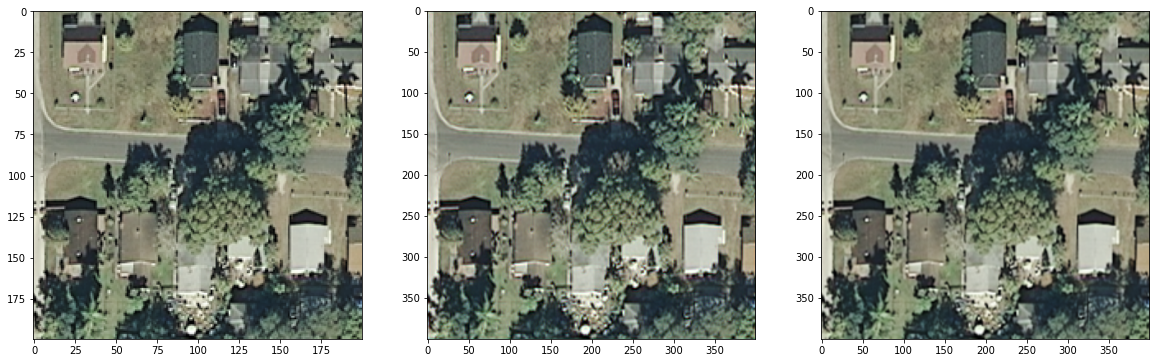

In [ ]:
_,axs=plt.subplots(1,3,figsize=(20,20))
ax=axs.flat
ax[0].imshow(tlr[0]/255.)
ax[1].imshow(pred[0])
ax[2].imshow(hlr/255.)

In [ ]:
K.models.save_model(sr_model,'sr_2x.h5')

In [ ]:
batchsize = len(val_list)
for i in vali

<generator object valid_generator at 0x7fe009370258>

In [ ]:
results = sr_model.evaluate(val_x_px, val_x)
print('val_loss, val_accuracy', results)

20/20 [==============================] - 6s 302ms/step - loss: -0.9162 - ssim: 0.9162 - psnr: 29.6015 - accuracy: 0.8957
val_loss, val_accuracy [-0.9162208437919617, 0.9162481427192688, 29.601533889770508, 0.8956902623176575]


In [ ]:
predictions = np.clip(autoencoder.predict(val_x_px),0.0,1.0)

In [ ]:
def Psnr(im1 , im2 , max_value = 1.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  psnr = tf.image.psnr(im1, im2, max_val= max_value)
  return float(psnr)

def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

def SSIM(im1 , im2 , max_value = 2.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  SSIM = tf.image.ssim(im1, im2, max_val= max_value)
  return float(SSIM)

In [ ]:
ssim = list(map(SSIM,predictions,val_x_px))
mse = list(map(mse, predictions, val_x_px))
Psnr = list(map(Psnr , predictions , val_x_px))

In [ ]:
metrics = pd.DataFrame(list(zip(ssim, Psnr, mse)), 
               columns =['SSIM','PSNR', 'mse' ]) 

In [ ]:
metrics.head()

,SSIM,PSNR,mse
0,0.896401,25.344442,0.008763
1,0.920372,25.351238,0.008750
2,0.921518,28.040144,0.004711
3,0.939619,30.798800,0.002496
4,0.945101,29.789986,0.003149


In [ ]:
metrics.mean(axis = 0)

SSIM     0.933506
PSNR    29.241267
mse      0.005145
dtype: float64